In [37]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt


In [38]:
df = pd.read_csv("data_zillow.csv")

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Columns: 312 entries, RegionID to 2025-07-31
dtypes: float64(307), int64(2), object(3)
memory usage: 2.1+ MB


In [40]:
# pd.set_option('display.max_columns', None)

In [41]:
print(df.head(5))

   RegionID  SizeRank       RegionName RegionType StateName     2000-01-31  \
0    102001         0    United States    country       NaN  124908.647735   
1    394913         1     New York, NY        msa        NY  223585.344443   
2    753899         2  Los Angeles, CA        msa        CA  225639.777055   
3    394463         3      Chicago, IL        msa        IL  159124.374736   
4    394514         4       Dallas, TX        msa        TX  129889.939824   

      2000-02-29     2000-03-31     2000-04-30     2000-05-31  ...  \
0  125128.402089  125400.929845  125985.448387  126658.159150  ...   
1  224535.456006  225494.367314  227437.492677  229449.666280  ...   
2  226479.443314  227597.870765  229823.165684  232256.940692  ...   
3  159271.677552  159552.218361  160250.134174  161089.642950  ...   
4  129947.793257  130014.301701  130187.017143  130414.737725  ...   

      2024-10-31     2024-11-30     2024-12-31     2025-01-31     2025-02-28  \
0  368814.621647  369318.59645

In [42]:
df_temp = df.loc[:,'2010-01-31':].dropna()

In [43]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 719 entries, 0 to 893
Columns: 187 entries, 2010-01-31 to 2025-07-31
dtypes: float64(187)
memory usage: 1.0 MB


In [44]:
df_long = df.melt(
    id_vars=["RegionID", "SizeRank", "RegionName", "RegionType", "StateName"], 
    var_name="Date", 
    value_name="Value"
)

# Convert Date to datetime
df_long["Date"] = pd.to_datetime(df_long["Date"], errors="coerce")

# Drop rows where Value is missing (optional, but common in Zillow data)
df_long = df_long.dropna(subset=["Value"])

# Preview
print(df_long.head(10))

   RegionID  SizeRank        RegionName RegionType StateName       Date  \
0    102001         0     United States    country       NaN 2000-01-31   
1    394913         1      New York, NY        msa        NY 2000-01-31   
2    753899         2   Los Angeles, CA        msa        CA 2000-01-31   
3    394463         3       Chicago, IL        msa        IL 2000-01-31   
4    394514         4        Dallas, TX        msa        TX 2000-01-31   
5    394692         5       Houston, TX        msa        TX 2000-01-31   
6    395209         6    Washington, DC        msa        VA 2000-01-31   
7    394974         7  Philadelphia, PA        msa        PA 2000-01-31   
8    394856         8         Miami, FL        msa        FL 2000-01-31   
9    394347         9       Atlanta, GA        msa        GA 2000-01-31   

           Value  
0  124908.647735  
1  223585.344443  
2  225639.777055  
3  159124.374736  
4  129889.939824  
5  125748.782522  
6  184643.822315  
7  125541.539940  
8  

In [45]:
# Sort by region and date
df_long = df_long.sort_values(["RegionName", "Date"])

# Create lag features, e.g., previous month value
df_long["Value_lag1"] = df_long.groupby("RegionName")["Value"].shift(1)
df_long["Value_lag2"] = df_long.groupby("RegionName")["Value"].shift(2)
df_long["Value_lag3"] = df_long.groupby("RegionName")["Value"].shift(3)

# Drop rows with NaN (first 3 months per region)
df_long = df_long.dropna()

In [46]:
X = df_long[["Value_lag1", "Value_lag2", "Value_lag3"]]
Y = df_long["Value"]

In [47]:
Input=[('scale',StandardScaler()), ('model',LinearRegression())]
pipe=Pipeline(Input)

In [48]:
X.shape, Y.shape

((222510, 3), (222510,))

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=33)
pipe.fit(X_train, Y_train)
Y_hat = pipe.predict(X_test)

In [50]:
print(r2_score(Y_test, Y_hat))
print(root_mean_squared_error(Y_test, Y_hat))

0.9999634882082872
744.9843051566273


<Axes: xlabel='Value'>

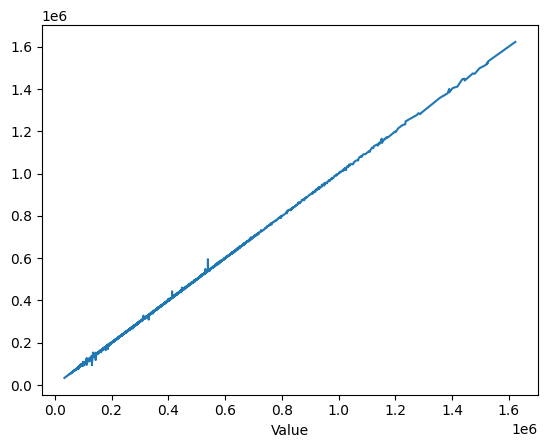

In [55]:
sns.lineplot(x=Y_test, y=Y_hat)

In [52]:
print(len(df_long['RegionName'].unique()))
print((df_long['RegionName'].unique()))

894
['Aberdeen, SD' 'Aberdeen, WA' 'Abilene, TX' 'Ada, OK' 'Adrian, MI'
 'Akron, OH' 'Alamogordo, NM' 'Albany, GA' 'Albany, NY' 'Albany, OR'
 'Albemarle, NC' 'Albert Lea, MN' 'Albertville, AL' 'Albuquerque, NM'
 'Alexandria, LA' 'Alexandria, MN' 'Alice, TX' 'Allentown, PA' 'Alma, MI'
 'Alpena, MI' 'Altoona, PA' 'Altus, OK' 'Amarillo, TX' 'Americus, GA'
 'Ames, IA' 'Amsterdam, NY' 'Anchorage, AK' 'Andrews, TX' 'Angola, IN'
 'Ann Arbor, MI' 'Anniston, AL' 'Appleton, WI' 'Arcadia, FL' 'Ardmore, OK'
 'Arkadelphia, AR' 'Asheville, NC' 'Ashland, OH' 'Ashtabula, OH'
 'Astoria, OR' 'Atchison, KS' 'Athens, GA' 'Athens, OH' 'Athens, TN'
 'Athens, TX' 'Atlanta, GA' 'Atlantic City, NJ' 'Auburn, AL' 'Auburn, IN'
 'Auburn, NY' 'Augusta, GA' 'Augusta, ME' 'Austin, MN' 'Austin, TX'
 'Bainbridge, GA' 'Bakersfield, CA' 'Baltimore, MD' 'Bangor, ME'
 'Baraboo, WI' 'Bardstown, KY' 'Barnstable Town, MA' 'Barre, VT'
 'Bartlesville, OK' 'Batavia, NY' 'Batesville, AR' 'Baton Rouge, LA'
 'Battle Creek, MI' 'Bay

In [53]:
# Filter for one region
# region = "New York, NY"
def show_plots(region):
    # print(f"Showing plots for {region}")
    df_region = df_long[df_long["RegionName"] == region][["Date", "Value"]]

    df_agg = df_region.groupby("Date")["Value"].mean().reset_index()

    # Prophet expects columns named 'ds' (date) and 'y' (value)
    df_prophet = df_agg.rename(columns={"Date": "ds", "Value": "y"})

    # Initialize and fit model
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False, changepoint_prior_scale=0.05)
    # model.add_seasonality(name='monthly', period=12, fourier_order=5)

    model.fit(df_prophet)

    # Make future dataframe (let's say 24 months ahead)
    future = model.make_future_dataframe(periods=24, freq="M")

    # Forecast
    forecast = model.predict(future)

    # Plot forecast
    fig1 = model.plot(forecast)
    plt.show()

    # # Plot forecast components (trend + seasonality)
    fig2 = model.plot_components(forecast)
    plt.show()


16:22:21 - cmdstanpy - INFO - Chain [1] start processing
16:22:22 - cmdstanpy - INFO - Chain [1] done processing


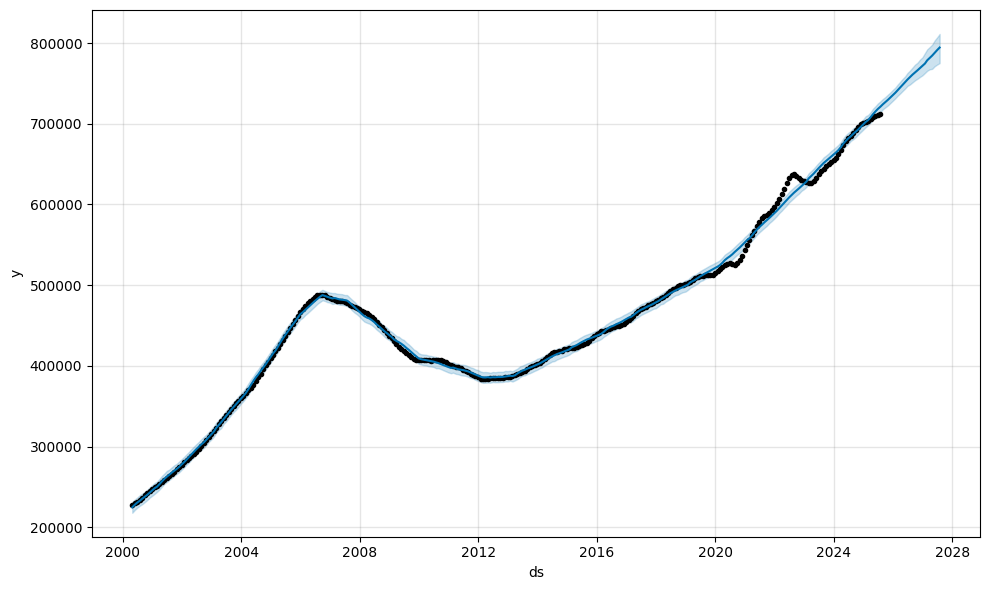

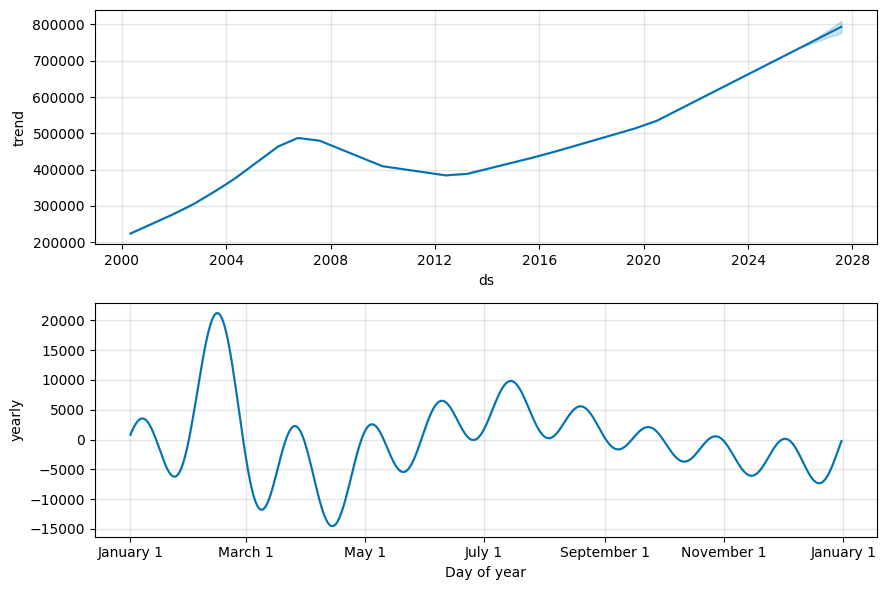

In [54]:
# region_input_value = input("Enter a region (e.g., 'New York, NY'): ")
region_input_value = "New York, NY"
show_plots(region_input_value)
